# Final Project DL model Notebook - sinple CNN model with two convolutional layers - v01

#### imports, settings and constants

In [1]:
import sys

from keras.models import Sequential
from keras.layers import BatchNormalization, Flatten, Dense, Conv2D, MaxPooling2D
from keras.optimizers import Adam
import numpy as np

from pathlib import Path

sys.path.append(str(Path.cwd().parent))
from utils import *

current_dir = Path.cwd()
HOME_DIR = current_dir.parent
DATA_DIR = HOME_DIR.joinpath('data')

# comment out one of the two path options to toggle between sample directory and all data
# path = DATA_DIR
path = DATA_DIR.joinpath('sample')
train_path = path.joinpath('train')
val_path = path.joinpath('valid')
test_path = path.joinpath('test')
results_path = path.joinpath('tesults')

# training variables
batch_size = 16
epochs = 4
learning_rate = 1e-4

Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

WARNING (theano.sandbox.cuda): CUDA is installed, but device gpu is not available  (error: Unable to get the number of gpus available: unknown error)


#### getting training and validation data in batches

In [2]:
batches = get_in_batches(train_path, batch_size=batch_size)
val_batches = get_in_batches(val_path, batch_size=batch_size)
test_batches = get_in_batches(test_path, batch_size=batch_size)

Found 1000 images belonging to 10 classes.
Found 200 images belonging to 10 classes.
Found 0 images belonging to 0 classes.


#### and getting the classes, labels and filenames for each batch

In [3]:
trn_classes = batches.classes
val_classes = val_batches.classes
trn_labels = onehot(batches.classes)
val_labels = onehot(val_batches.classes)
trn_filenames = batches.filenames
val_filenames = val_batches.filenames

#### defining CNN model

In [4]:
    model = Sequential([
            BatchNormalization(axis=1, input_shape=(3, 224, 224)),
            Conv2D(32, 3, activation='relu'),
            BatchNormalization(axis=1),
            MaxPooling2D((3,3)),
            Conv2D(64, 3, activation='relu'),
            BatchNormalization(axis=1),
            MaxPooling2D((3, 3)),
            Flatten(),
            Dense(200, activation='relu'),
            BatchNormalization(),
            Dense(10, activation='softmax')
    ])
model.compile(Adam(lr=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 3, 224, 224)       12        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 222, 222)      896       
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 222, 222)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 74, 74)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 72, 72)        18496     
_________________________________________________________________
batch_normalization_3 (Batch (None, 64, 72, 72)        256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 64, 24, 24)        0         
__________

#### fit_generator() consuming the batches provided by the ImageDataGenerator to fit the model to the data

In [5]:
history = model.fit_generator(batches,
                    steps_per_epoch=batches.batch_size,
                    validation_data=val_batches,
                    validation_steps=val_batches.batch_size,
                    epochs=epochs)

Epoch 1/4
16/16 [==============================] - 45s - loss: 2.6897 - acc: 0.2188 - val_loss: 4.7608 - val_acc: 0.1008

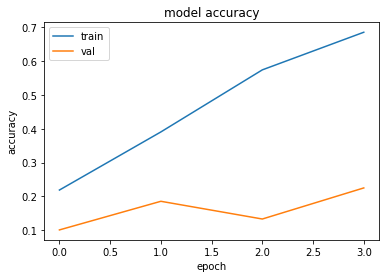

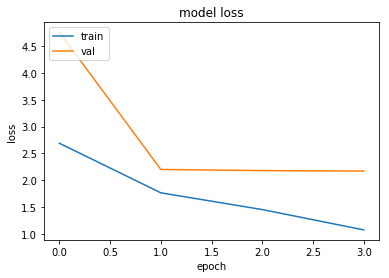

In [6]:
plot_acc_and_loss(history)

#### validating the model performance on the val set

In [7]:
rnd_batches = get_in_batches(val_path, batch_size=batch_size*2, shuffle=True)
val_res = [model.evaluate_generator(rnd_batches, rnd_batches.samples) for i in range(epochs)]
np.round(val_res, 3)
print(val_res)

Found 200 images belonging to 10 classes.
[[2.1984940414322156, 0.20006983240223464], [2.1981451965910095, 0.19954608938547486], [2.1985344129391171, 0.19985974754558206], [2.1962655227615655, 0.2005610098176718]]


#### test performance and plot confusion matrix on one batch of 200 images

In [8]:
test_set = get_in_batches(val_path, shuffle=False, class_mode=None, batch_size=200)
pred_classes = model.predict_generator(test_set, 1)
pred_classes = np.argmax(pred_classes, axis=1)
act_classes = test_set.classes

Found 200 images belonging to 10 classes.


[[14  0  0  0  0  0  0  0  0  6]
 [ 1  0  0  0  0  0  0  0  0 19]
 [ 2  0  0  0  0  0  0  0  0 18]
 [ 5  0  0  0  0  0  0  0  0 15]
 [ 1  0  0  0  0  0  0  0  0 19]
 [ 1  0  0  0  0  1  0  0  0 18]
 [ 2  0  0  0  0  0  0  0  0 18]
 [ 0  0  0  0  0  0  0  5  0 15]
 [ 0  0  0  0  0  0  0  0  0 20]
 [ 0  0  0  0  0  0  0  0  0 20]]


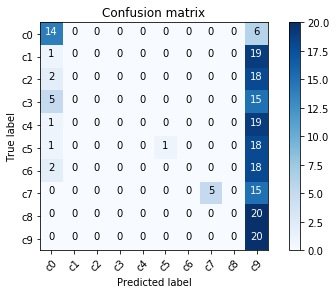

In [9]:
cm = confusion_matrix(act_classes, pred_classes)
plot_confusion_matrix(cm, val_batches.class_indices)
plt.figure()
plt.show()

In [10]:
model.optimizer.lr = 1e-5
history = model.fit_generator(batches,
                    steps_per_epoch=batches.batch_size,
                    validation_data=val_batches,
                    validation_steps=val_batches.batch_size,
                    epochs=epochs)

Epoch 1/4
16/16 [==============================] - 43s - loss: 0.5247 - acc: 0.8867 - val_loss: 2.2171 - val_acc: 0.1875

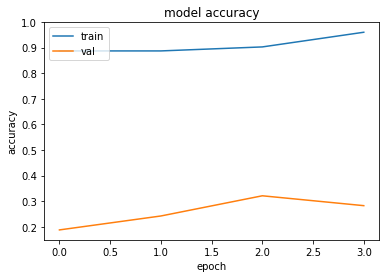

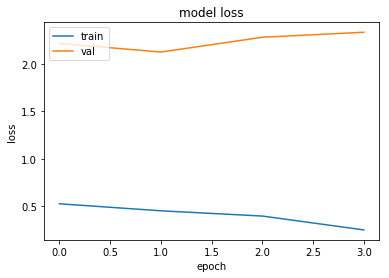

In [11]:
plot_acc_and_loss(history)

In [12]:
rnd_batches = get_in_batches(val_path, batch_size=batch_size*2, shuffle=True)
val_res = [model.evaluate_generator(rnd_batches, rnd_batches.samples) for i in range(epochs)]
np.round(val_res, 3)
print(val_res)

Found 200 images belonging to 10 classes.
[[2.3126508178990646, 0.27898044692737428], [2.3113400182081976, 0.28068022440392709], [2.3083129353810827, 0.28015427769985973], [2.3098171416607647, 0.27950418994413406]]


In [13]:
test_set = get_in_batches(val_path, shuffle=False, class_mode=None, batch_size=200)
pred_classes = model.predict_generator(test_set, 1)
pred_classes = np.argmax(pred_classes, axis=1)
act_classes = test_set.classes

Found 200 images belonging to 10 classes.


[[20  0  0  0  0  0  0  0  0  0]
 [14  0  0  0  0  0  0  0  0  6]
 [18  0  0  0  0  0  0  0  0  2]
 [15  0  0  0  0  0  0  0  0  5]
 [ 8  0  0  0 12  0  0  0  0  0]
 [16  0  0  0  0  1  0  0  0  3]
 [11  0  0  0  0  0  1  0  0  8]
 [ 6  0  0  0  0  0  0  8  0  6]
 [18  0  0  0  0  0  0  0  0  2]
 [ 6  0  0  0  0  0  0  0  0 14]]


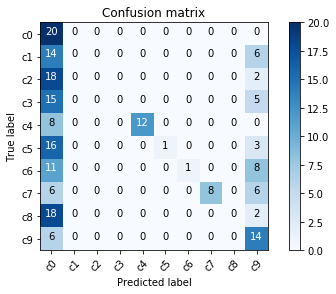

In [14]:
cm = confusion_matrix(act_classes, pred_classes)
plot_confusion_matrix(cm, val_batches.class_indices)
plt.figure()
plt.show()

In [15]:
pred_classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9,
       9, 0, 0, 0, 9, 0, 9, 0, 0, 0, 0, 0, 0, 0, 9, 9, 0, 0, 0, 0, 0, 9, 0,
       0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 9,
       0, 0, 0, 0, 9, 9, 0, 0, 0, 9, 0, 0, 4, 0, 0, 4, 4, 4, 4, 4, 0, 0, 4,
       0, 0, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 9, 0, 0,
       0, 0, 9, 0, 9, 0, 9, 0, 0, 0, 9, 0, 9, 9, 0, 0, 0, 6, 9, 0, 9, 9, 0,
       9, 0, 7, 0, 9, 9, 7, 7, 0, 0, 9, 9, 9, 7, 9, 7, 0, 7, 7, 7, 0, 0, 0,
       9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 9, 9, 0, 0,
       9, 9, 0, 9, 9, 9, 9, 9, 9, 9, 9, 0, 9, 0, 9, 0])

In [16]:
act_classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9], dtype=int32)